# Analyzing SASUMO outputs

In [1]:
%%capture
# !pip install SALib
# !pip install pint-pandas

In [1]:
import os
import json
import sys
import pickle
import csv

import pandas as pd 
import pint
import pint_pandas
import plotly.graph_objects as go

from SALib.analyze import sobol

In [2]:
ureg = pint.UnitRegistry()

In [3]:
def find_root(path):
    if os.path.split(path)[-1] != 'airport-harper-sumo':
        return find_root(os.path.split(path)[0])
    return path

In [4]:
PATH = !pwd  # a bit of Jupyter Magic to get the working path
PATH = find_root(PATH[0])
if PATH not in sys.path:
    print(f"adding {PATH} to path")
    sys.path.append(PATH)

adding /home/max/remote/airport-harper-sumo to path


In [5]:
# sys.path.append(os.path.join(ROOT, 'SASUMO', 'SASUMO', 'params'))

In [6]:
from SASUMO.SASUMO.params import Settings4SASUMO

## Defining the Analysis Root

In [11]:
ROOT = "/media/HDD/max/sasumo-files/630AM_6_Parameter/2021_09_16-10_17_39"
TOP_LEVEL_SETTINGS = os.path.join(ROOT, "settings.yaml")
OUTPUT= os.path.join(ROOT, "output.txt")
PROBLEM = os.path.join(ROOT, "SALib_Problem.json")

In [12]:
# with open(TOP_LEVEL_SETTINGS, 'rb') as f:
settings = Settings4SASUMO(TOP_LEVEL_SETTINGS)

## Open up the Problem

In [13]:
with open(PROBLEM, 'r') as f:
    problem = json.load(f)
problem

{'num_vars': 6,
 'names': ['FleetComposition_fleet_composition',
  'CarFollowingParameters_delta',
  'PersonalCar_tau',
  'PersonalCar_accel',
  'Class8Truck_tau',
  'Class8Truck_accel'],
 'bounds': [[0.0, 0.7], [1, 10], [0.5, 3], [2.5, 6], [0.5, 3], [1, 3]]}

## Creating a table of the Results and Parameters

In [14]:
# try:
#     results_df = pd.read_csv(OUTPUT)
# except FileNotFoundError:
# incase of errors just read in the results from individual text files
results = []
param_keys = []
for _dir in os.scandir(ROOT):
    if _dir.is_dir():
        # reading the fuel consumption in 
        try:
            with open(os.path.join(_dir.path, 'f_out.txt'), 'r') as f:
                fc = float(f.read())
        except:
            pass
        with open(os.path.join(_dir.path, 'sa_values.json'), 'r') as f:
            _d = json.loads(f.read())
            if not param_keys:
                param_keys = list(_d.keys())
            params = [_d[_k] for _k in param_keys]
        results.append([int(_dir.name.split("_")[1]), fc, *params])
            
        
results_df = pd.DataFrame.from_records(results, columns=['Sample_Num', 'f_out', *param_keys],)

# results_df.
results_df.set_index('Sample_Num', inplace=True)
results_df.sort_index(inplace=True)
results_np = results_df['f_out'].values
# results_df.head()

In [15]:
results_df['Fuel [gal]'] = results_df['f_out'] * (1* ureg.milliliter).to('gallon').magnitude
results_df.head()

f_out  FleetComposition_fleet_composition  \
Sample_Num                                                      
0           289506.324001                                 0.0   
1           295707.247002                                 0.0   
2           285567.354001                                 0.0   
3           294529.305002                                 0.0   
4           291122.199001                                 0.0   

            CarFollowingParameters_delta  PersonalCar_tau  PersonalCar_accel  \
Sample_Num                                                                     
0                                    1.0              0.5                2.5   
1                                    1.0              0.5                2.5   
2                                    1.0              0.5                2.5   
3                                    1.0              0.5                2.5   
4                                    1.0              0.5                2.5   

            Class8Truck_tau  Class8Truck_accel  Fuel [gal]  
Sample_Num                                                  
0                       0.5                1.0   76.479480  
1                       0.5                1.0   78.117590  
2                       0.5                1.0   75.438914  
3                       0.5                1.0   77.806411  
4                       0.5                1.0   76.906349

## Perform the Sobol Analysis

In [16]:
Si = sobol.analyze(problem, results_np, print_to_console=False, calc_second_order=True)
first_order_df = Si.to_df()[0]
second_order_df = Si.to_df()[1]

In [17]:
first_order_df

ST   ST_conf
FleetComposition_fleet_composition  0.984707  0.142627
CarFollowingParameters_delta        0.167675  0.038972
PersonalCar_tau                     0.166987  0.029336
PersonalCar_accel                   0.159858  0.026908
Class8Truck_tau                     0.172336  0.033773
Class8Truck_accel                   0.179172  0.035336

In [20]:
second_order_df

S1   S1_conf
FleetComposition_fleet_composition  0.755838  0.147808
CarFollowingParameters_delta        0.013889  0.081489
PersonalCar_tau                     0.024050  0.066524
PersonalCar_accel                   0.027477  0.070821
Class8Truck_tau                     0.040773  0.071845
Class8Truck_accel                  -0.005898  0.074035

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

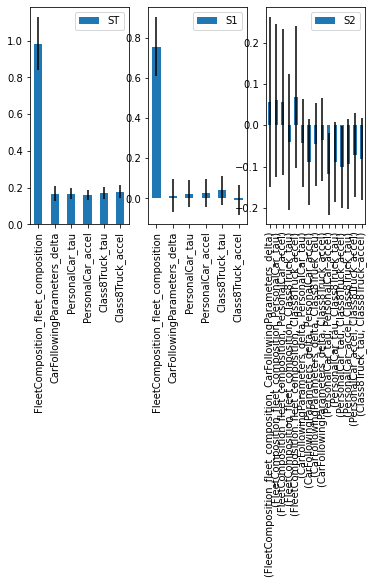

In [21]:
Si.plot()

### Plotting the Results

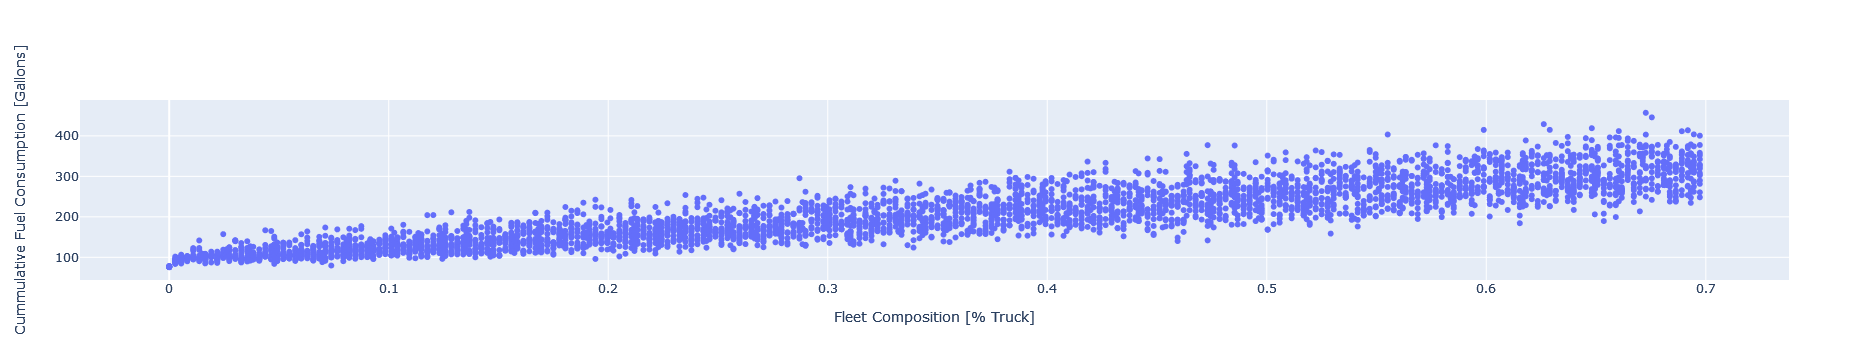

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df['FleetComposition_fleet_composition'], y=results_df['Fuel [gal]'], mode='markers'))
fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='Fleet Composition [% Truck]')
                 )
fig.show()

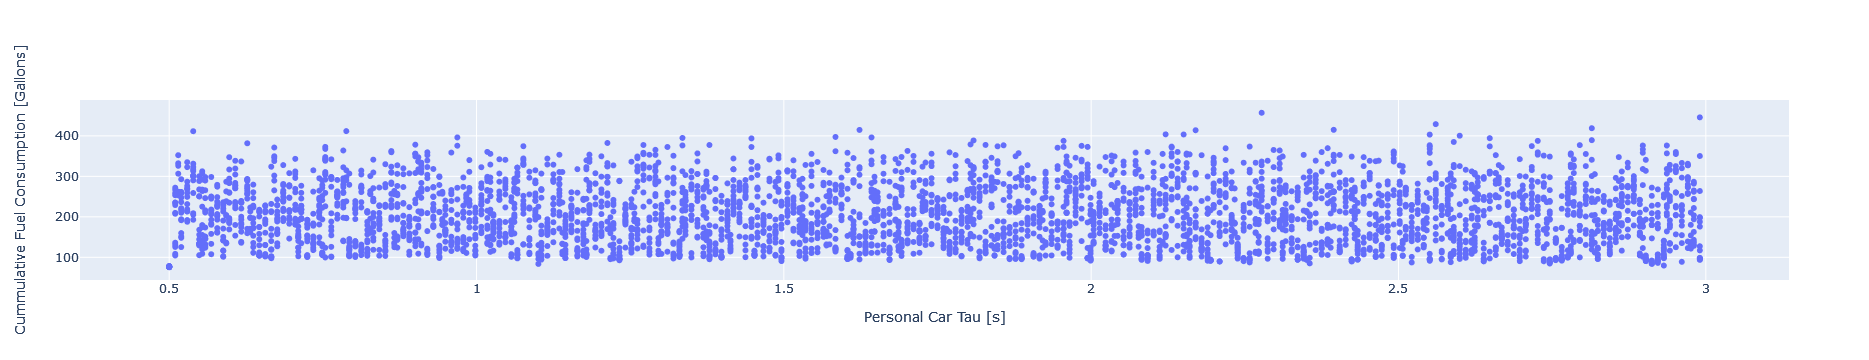

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df['PersonalCar_tau'], y=results_df['Fuel [gal]'], mode='markers'))
fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='Personal Car Tau [s]')
                 )
fig.show()

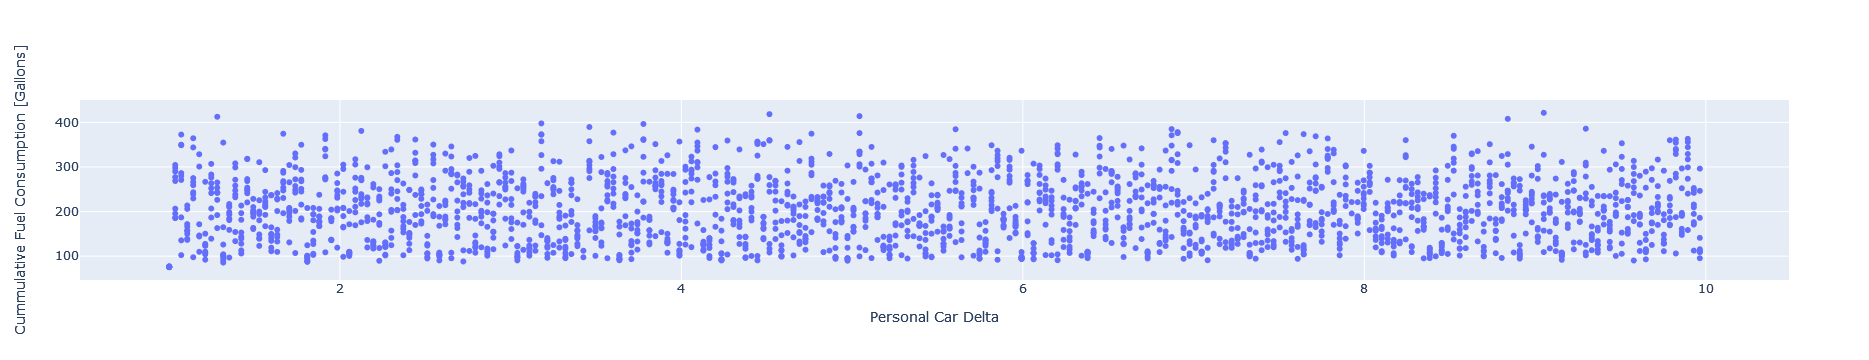

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df['PersonalCar_delta'], y=results_df['Fuel [gal]'], mode='markers'))
fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='Personal Car Delta')
                 )
fig.show()

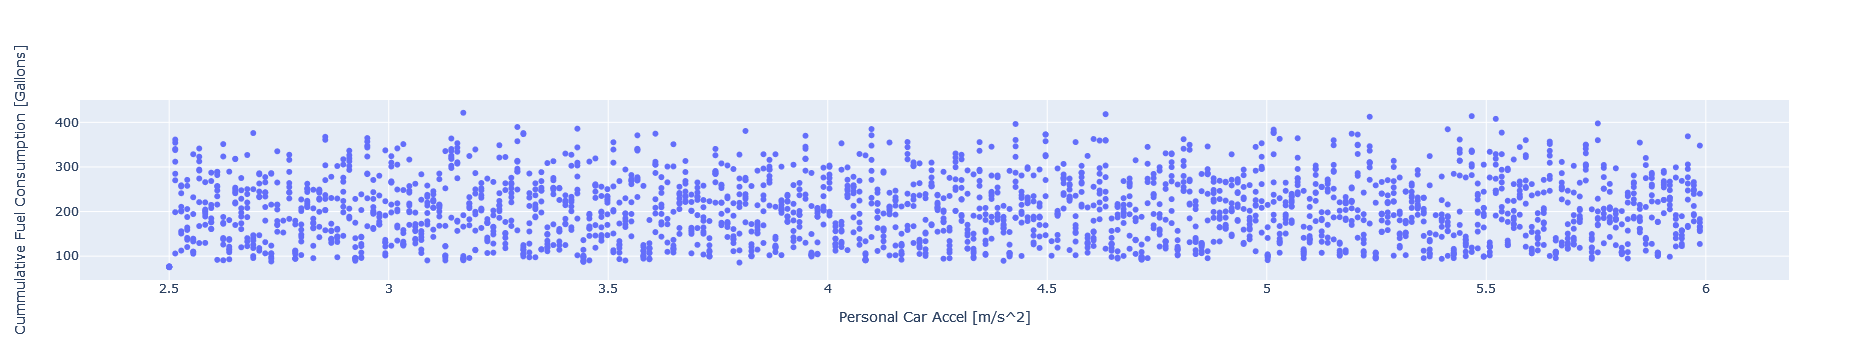

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df['PersonalCar_accel'], y=results_df['Fuel [gal]'], mode='markers'))
fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='Personal Car Accel [m/s^2]')
                 )
fig.show()

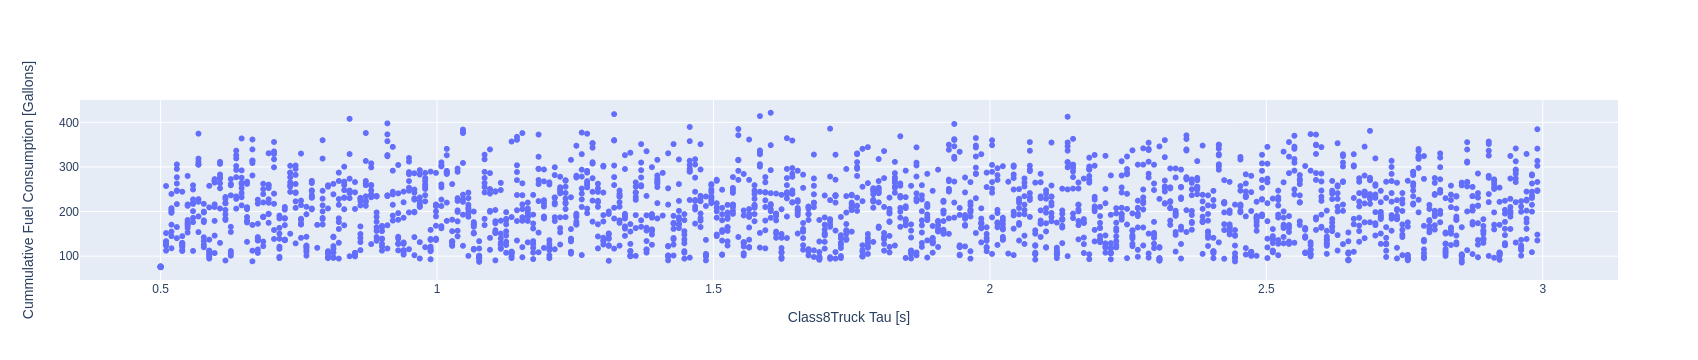

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df['Class8Truck_tau'], y=results_df['Fuel [gal]'], mode='markers'))
fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='Class8Truck Tau [s]')
                 )
fig.show()

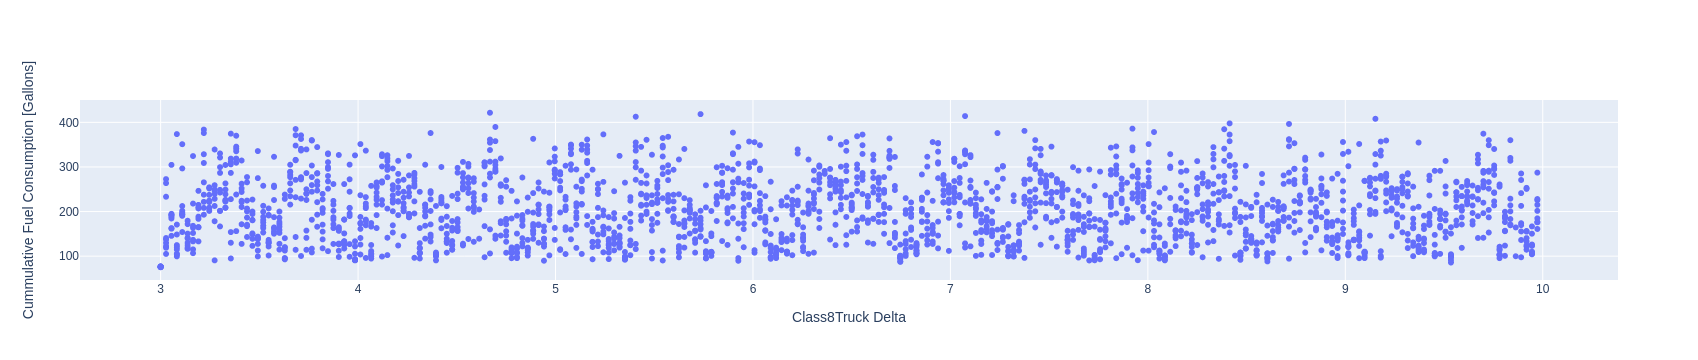

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df['Class8Truck_delta'], y=results_df['Fuel [gal]'], mode='markers'))
fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='Class8Truck Delta')
                 )
fig.show()

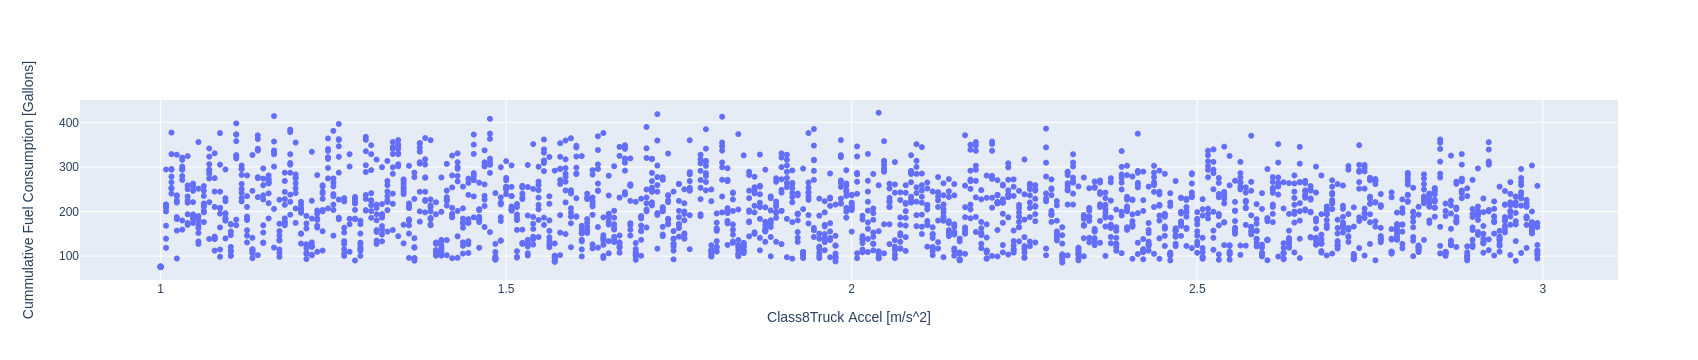

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df['Class8Truck_accel'], y=results_df['Fuel [gal]'], mode='markers'))
fig.update_layout(yaxis=dict(title="Cummulative Fuel Consumption [Gallons]"),
                  xaxis=dict(title='Class8Truck Accel [m/s^2]')
                 )
fig.show()